In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import scipy.io as sio
from scipy.sparse.linalg import eigsh

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = Path('drive/My Drive/Colab Notebooks/Neuroscience')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def divide_space(path, mat, kind, denoising=True):
  mt = sio.loadmat(path/f'data/{kind}/{mat}')
  classes = pd.read_csv(path/'class_map.csv')
  responses = mt['stim'][0]['resp'][0] # stim x neurons
  spont = mt['stim'][0]['spont'][0] # timepts x neurons
  istim = (mt['stim'][0]['istim'][0]).astype(np.int32) # stim ids 

  if denoising:
    istim -= 1
    istim = istim[:,0]
    nimg = istim.max() # these are blank stims (exclude them)
    responses = responses[istim<nimg, :]
    istim = istim[istim<nimg]

    mu = spont.mean(axis=0) # get rid of spontaneous noise
    sd = spont.std(axis=0) + 1e-6
    responses = (responses - mu) / sd
    spont = (spont - mu) / sd
    sv,u = eigsh(spont.T @ spont, k=32)
    responses = responses - (responses @ u) @ u.T
    # mean center each neuron
    responses -= responses.mean(axis=0)
    filename = path/f"data/{kind}/{mat.split('.')[0]}_divided_denoised.csv"
  else:
    filename = path/f"data/{kind}/{mat.split('.')[0]}_divided.csv"

  labels = classes.iloc[istim.flatten() - 1, -2].reset_index(drop=True).to_numpy().flatten()
  
  spatial = mt['med']
  xs = spatial[:, 0].astype('int')
  ys = spatial[:, 1].astype('int')
  zs = spatial[:, 2].astype('int')

  bins = [(0+i*200, 200+i*200) for i in range(6)]
  subspaces = [(x, y, z) for x in bins for y in bins for z in np.unique(zs)]
  
  data = pd.DataFrame()
  
  for i, subspace in enumerate(subspaces):
    x, y, z = subspace
    X_idx = (xs > x[0]) & (xs < x[1])
    Y_idx = (ys > y[0]) & (ys < y[1])
    Z_idx = zs == z
    if responses[:, X_idx & Y_idx & Z_idx].size == 0:
      subspace_feat = 0
    else:
      subspace_feat = responses[:, X_idx & Y_idx & Z_idx].mean(axis=1)
    data[i] = subspace_feat
  
  data["label"] = labels
  
  data.to_csv(filename, index=False)

In [0]:
kind = 'normal'
filenames = [file.name for file in os.scandir(path/f'data/{kind}') if file.name.endswith('mat')]

In [10]:
for file in tqdm(filenames):
  divide_space(path, file, kind)

## Loading data


In [0]:
dfs = [pd.read_csv(path/f"data/{kind}/{mat.split('.')[0]}_divided.csv") for mat in filenames]
data = pd.concat(dfs, ignore_index=True)
data = data.dropna(axis=1, how='all').fillna(0)

test = pd.read_csv(path/f"data/{kind}/{filenames[0].split('.')[0]}_divided.csv", usecols=data.columns)
test = test.fillna(0)

In [0]:
dfs = [pd.read_csv(path/f"data/{kind}/{mat.split('.')[0]}_divided_denoised.csv") for mat in filenames]
data = pd.concat(dfs, ignore_index=True)
data = data.dropna(axis=1, how='all').fillna(0)
data = data[data.label != 12]

test = pd.read_csv(path/f"data/{kind}/{filenames[0].split('.')[0]}_divided_denoised.csv", usecols=data.columns)
test = test.fillna(0)
test = test[test.label != 12]

# Training

## Sklearn - Ada Boost, RandomForest, XGBoost



In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-2].values, data.iloc[:, -1].values)


In [0]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### AdaBoost

In [0]:
model = AdaBoostClassifier(n_estimators=100)

In [32]:
cross_val_score(model, X_test, y=y_test, cv=5).mean()

0.13465176464310574

### Random forest

In [0]:
model = RandomForestClassifier(n_estimators=100)

In [34]:
cross_val_score(model, X_train, y=y_train, cv=5).mean()

0.13678759540275184

### XGBoost

In [0]:
model = XGBClassifier()

In [36]:
cross_val_score(model, X_test, y=y_test, cv=5).mean()

0.14548862095645573

## KNN

In [48]:
model = KNeighborsClassifier(n_neighbors=5)
cross_val_score(model, X_test, y=y_test, cv=5).mean()

0.12657668211684409

## Fast.ai tabular

In [0]:
from fastai.tabular import *

In [0]:
data['label'] = data['label'].astype('category')

procs = [Normalize, Categorify]
valid_idx = np.random.choice(len(data), len(data)//4)

dep_var = 'label'

In [0]:
datab = TabularDataBunch.from_df(path, data, dep_var='label', valid_idx=valid_idx, test_df=test)

In [40]:
datab.show_batch()

135,161,198,60,239,347,380,388,65,247,387,146,156,127,314,360,265,228,27,103,250,303,192,232,21,46,364,258,42,47,278,176,248,62,150,305,155,385,88,164,268,254,86,160,115,144,66,35,72,309,365,261,302,301,76,121,233,44,26,172,116,204,225,281,226,32,340,24,143,337,256,104,93,5,354,165,6,377,209,243,224,259,308,331,194,4,237,1,63,25,238,17,307,371,90,152,381,28,101,318,52,10,320,351,124,31,185,393,286,227,253,78,36,218,29,45,141,122,373,279,201,359,33,264,94,362,167,230,110,267,358,316,112,57,221,310,92,79,240,213,266,262,30,74,134,183,277,49,255,295,80,350,374,157,178,54,273,162,109,249,174,187,390,271,289,153,334,349,69,3,123,75,379,132,118,139,231,378,317,106,384,182,270,89,83,40,383,296,236,168,82,203,263,319,67,0,376,131,251,280,285,8,58,133,229,149,344,53,298,77,177,170,147,211,348,136,193,338,274,128,343,283,108,12,175,19,345,138,366,142,173,361,352,186,197,357,120,287,9,171,330,96,306,87,332,117,324,37,7,363,70,234,323,43,336,315,130,216,291,394,335,282,196,95,119,392,14,20,217,59,105,137,190,55,241,50,369,391,257,151,235,73,329,311,188,386,382,18,111,367,84,107,129,202,219,199,205,207,375,284,98,100,215,242,169,292,126,272,304,39,208,64,16,113,34,189,38,322,15,159,210,333,180,276,313,326,222,220,166,389,325,300,293,91,245,181,145,61,297,22,148,246,341,206,214,339,179,368,342,114,346,191,2,356,223,163,154,13,41,299,68,51,140,275,158,71,56,200,23,99,81,260,353,244,294,269,355,370,48,290,328,252,184,395,312,125,195,85,372,321,327,97,288,212,102,11,target
0.0831,-0.0196,-0.3068,1.0898,-0.5317,0.0000,0.0000,0.0000,-0.3612,0.0629,0.0000,-0.1537,0.1589,0.0000,0.0000,0.0000,0.0000,0.1211,-0.0069,-0.1187,-0.4114,0.2585,-0.3453,0.3833,-0.3200,-0.0718,0.0000,0.0000,0.1019,-0.2350,0.4765,0.0482,0.0000,-0.8168,-0.2033,0.6663,-0.3090,0.0000,-0.3130,-0.4159,0.0000,0.0000,-0.0671,-0.4048,-0.1023,-0.1505,0.2928,0.0563,-0.1858,0.6295,0.0000,0.0000,1.4270,-0.1566,-0.1900,0.0379,-0.1423,-0.1266,0.0040,0.2988,-0.0501,-0.5356,-0.3925,0.0960,-0.2220,-0.0044,0.0000,-0.0350,-0.3660,0.0000,2.5796,-0.1066,-0.1605,0.1984,-0.5472,-0.1672,-0.0362,0.0000,-0.1563,0.1628,-0.2522,0.0000,-0.3539,0.0000,-0.4365,0.2242,-0.7962,0.0566,-0.2138,0.0544,0.1169,0.2134,1.0170,0.0000,-0.3662,-0.1347,0.0000,0.4971,0.1056,0.0000,0.1583,-0.1916,-0.8900,0.0000,0.1799,0.2369,0.0391,0.0000,0.1186,0.4245,3.2192,0.2022,-0.2990,0.3013,-0.0696,-0.1775,-0.0072,-0.7905,0.0000,-0.1058,0.2843,0.0000,0.1050,1.1558,-0.2047,0.0000,0.2306,-0.2009,-0.1696,0.0000,0.0000,0.0000,0.1565,-0.2160,-0.2054,-0.1592,-0.1934,-0.1957,0.3809,-0.3970,0.0000,0.0000,-0.0024,-0.0350,0.1723,-0.0906,-0.1310,-0.0922,-0.0055,0.0854,-0.1728,0.0000,-0.9173,-0.1207,0.0192,-0.1470,0.0000,-0.1486,-0.1576,-0.8689,0.0730,0.0000,0.0000,-0.6418,0.0905,0.0817,0.0000,0.0000,-0.0960,-0.3008,-0.4471,0.0330,0.0000,0.1958,-0.0329,-0.0659,0.1146,0.0000,0.0000,-0.0481,0.0000,0.0002,-0.4005,0.2495,0.0295,0.2840,0.0000,-0.3341,0.1766,-0.4673,0.0636,0.2180,0.0000,-0.7620,-0.0908,-0.4143,0.0000,0.0289,-0.6500,0.8539,0.2563,-0.1748,-1.0800,0.6200,0.0919,-0.2670,0.0000,0.0361,0.4439,-0.2166,0.0307,0.1800,-0.0530,-0.2307,0.0000,-0.1047,-0.6476,0.0000,0.6953,-0.6584,0.0000,0.0369,0.0710,-0.4081,0.2579,0.2190,0.0000,0.4749,0.0000,-0.0031,-0.1446,0.0000,0.0000,-0.2475,0.0000,0.0000,-0.0225,-0.3313,-0.1090,0.3270,0.0000,-0.2647,-0.7715,-0.1264,0.0000,-0.1942,0.0000,-0.1763,-0.3067,0.0000,-0.0655,0.4791,0.0000,-0.2033,0.0000,0.0000,0.0000,-0.1612,0.4150,0.0000,0.0000,0.0391,-0.9784,0.1904,-0.2541,0.0000,-0.3513,0.1603,-0.1279,0.3192,0.3622,-0.1561,0.1374,-0.6624,-0.1433,-0.1814,0.0000,0.0000,0.0000,-0.1792,-0.8802,-0.2276,0.0000,-1.1105,0.5821,0.0000,0.0000,0.2489,0.0406,0.0000,-0.0782,-0.0425,0.1858,0.4118,-0.2129,-0.1884,0.1562,-0.2362,0.0000,-0.1940,-0.1617,-0.0038,-0.0730,0.9468,0.2943,-0.0206,-0.6577,-0.7089,0.7533,0.6744,0.1738,-0.4524,0.0871,-0.0826,0.3127,-0.2376,0.2148,0.0000,-0.1938,-0.2053,-0.2902,0.0000,0.0391,-0.1086,-0.4662,0.0000,0.4870,-0.2802,-0.0812,0.0000,0.0000,0.1696,0.0316,-0.0391,-0.2608,-0.2320,0.1188,-0.6957,

In [0]:
recall = Recall('macro')
learner = tabular_learner(datab, [10000, 1000, 200, 13],
                          ps=[0.01],
                          metrics=[recall, accuracy],
                          loss_func=nn.CrossEntropyLoss())

epoch,train_loss,valid_loss,recall,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


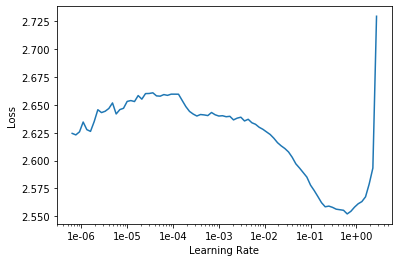

In [42]:
learner.lr_find()
learner.recorder.plot()

In [43]:
learner.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,recall,accuracy,time
0,2.327333,2.345465,0.084224,0.129334,00:08
1,2.340079,452210624.000000,0.084018,0.142041,00:08
2,2.323243,13815500800.000000,0.083187,0.124310,00:08
3,2.303894,6143786496.000000,0.087071,0.136131,00:08
4,2.290259,1163193600.000000,0.094102,0.143814,00:08


## Testing

In [44]:
interp = ClassificationInterpretation.from_learner(learner)

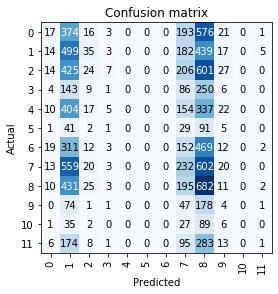

In [45]:
fig = interp.plot_confusion_matrix()
plt.savefig(path/"confusion_matrix_subspace_ANN")

## Try importance of features

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = data.iloc[:, :-2]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

    Specs         Score
354   366  20770.630402
355   367  18053.765729
330   333  17350.242260
338   348  17255.831761
220   220  15635.360421
231   231  15620.908999
165   165  14627.302339
176   176  14590.667563
223   223  14404.646180
297   297  14087.813804
